# cosine

发现该scheduler是每个batch执行一次更新（step）

In [ ]:
"""
参考openclip
python -m open_clip_train.main \
    --save-frequency 1 \
    --zeroshot-frequency 1 \
    --report-to tensorboard \
    --train-data="/path/to/train_data.csv"  \
    --val-data="/path/to/validation_data.csv"  \
    --csv-img-key filepath \
    --csv-caption-key title \
    --imagenet-val=/path/to/imagenet/root/val/ \
    --warmup 10000 \
    --batch-size=128 \
    --lr=1e-3 \
    --wd=0.1 \
    --epochs=30 \
    --workers=8 \
    --model RN50
"""

ref： https://medium.com/better-ml/the-art-of-setting-learning-rate-eff11ac0a737


In [2]:
import math
def _warmup_lr(base_lr, warmup_length, step):
    return base_lr * (step + 1) / warmup_length
    
def cosine_lr(optimizer, base_lr, warmup_length, steps):
    def _lr_adjuster(step):
        if step < warmup_length:
            lr = _warmup_lr(base_lr, warmup_length, step)
        else:
            e = step - warmup_length
            es = steps - warmup_length
            lr = 0.5 * (1 + math.cos(math.pi * e / es)) * base_lr
        # assign_learning_rate(optimizer, lr)
        return lr

    return _lr_adjuster

In [ ]:
# in train_one_epoch()
# ...
# accu_freq:This is the gradient accumulation frequency. 
# If you're using gradient accumulation, 
# the model doesn't update the weights after every batch, 
# but after accumulating gradients for accum_freq
# assume accu_freq=1 for simplicity

"""
for i, batch in enumerate(dataloader):
    i_accum = i // args.accum_freq
    # the step here is actually for accounting the update times of optimizer.step()
    # if accum_freq=1，then optimizer would update for every batch
    step = num_batches_per_epoch * epoch + i_accum

    if not args.skip_scheduler:
        scheduler(step)
"""
# ...

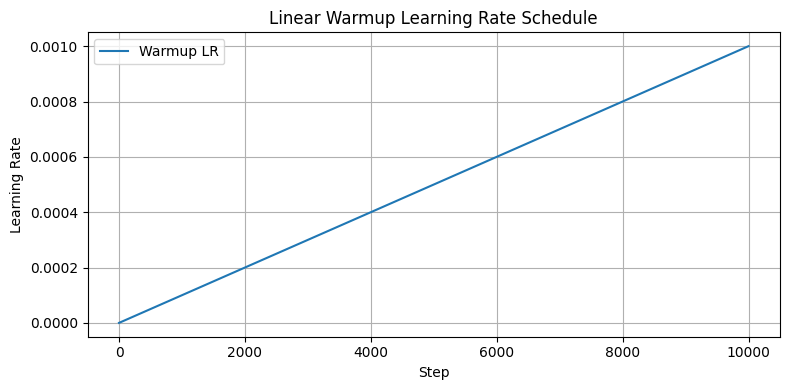

In [2]:
import matplotlib.pyplot as plt

def _warmup_lr(base_lr, warmup_length, step):
    return base_lr * (step + 1) / warmup_length

# Settings
base_lr = 0.001
warmup_length = 10000  # number of steps for warmup
steps = list(range(warmup_length))  # simulate steps 0 to warmup_length - 1

# Compute learning rates
lrs = [_warmup_lr(base_lr, warmup_length, step) for step in steps]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(steps, lrs, label="Warmup LR")
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Linear Warmup Learning Rate Schedule")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


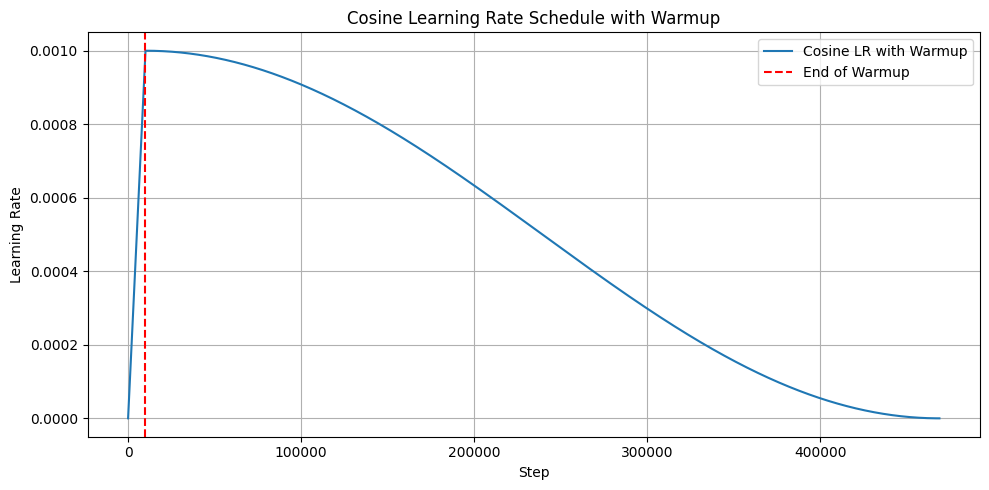

In [6]:
# total_steps = (number of training samples / batch size) * number of epochs
# assume use LAION-2B, and batch size = 128, epoch = 30
# total_steps = (2,000,000,000 / 128) * 30
            # ≈ 15,625,000 * 30
            # = 468,750,000 steps
import matplotlib.pyplot as plt
base_lr = 0.001
warmup_length = 10000 
total_steps = 468750
lr_fn = cosine_lr(None, base_lr, warmup_length, total_steps)
# Simulate learning rate schedule
steps = list(range(total_steps))
lrs = [lr_fn(step) for step in steps]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(steps, lrs, label='Cosine LR with Warmup')
plt.axvline(warmup_length, color='red', linestyle='--', label='End of Warmup')
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Cosine Learning Rate Schedule with Warmup")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

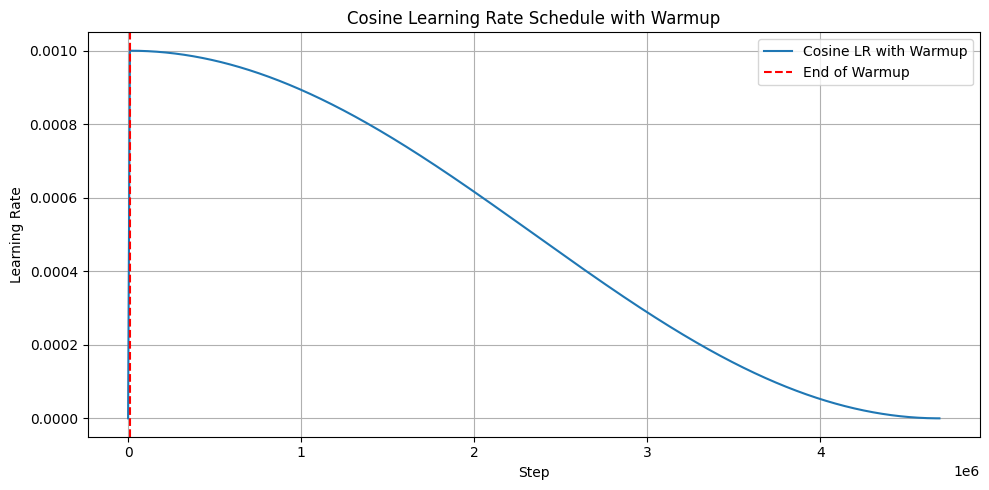

In [7]:
base_lr = 0.001
warmup_length = 10000 
total_steps = 4687500
lr_fn = cosine_lr(None, base_lr, warmup_length, total_steps)
# Simulate learning rate schedule
steps = list(range(total_steps))
lrs = [lr_fn(step) for step in steps]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(steps, lrs, label='Cosine LR with Warmup')
plt.axvline(warmup_length, color='red', linestyle='--', label='End of Warmup')
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Cosine Learning Rate Schedule with Warmup")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# MultiStepLR

发现该scheduler是每个epoch执行一次更新（step）

/home/cwy/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


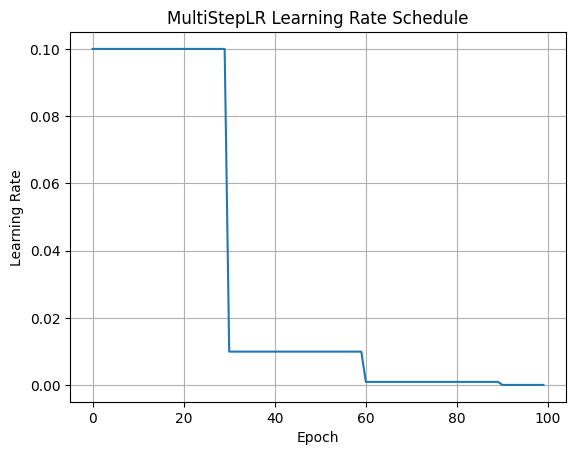

In [1]:
import torch
import matplotlib.pyplot as plt

optimizer = torch.optim.SGD([torch.nn.Parameter(torch.randn(2, 2))], lr=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)

lrs = []
for epoch in range(100):
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

plt.plot(range(100), lrs)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("MultiStepLR Learning Rate Schedule")
plt.grid()
plt.show()


**常用设置**

LR decay start epoch: 1/3 or 1/2 of total epochs

Gamma (decay rate): start with 0.1 (a 10× drop); you can also use 0.2 or 0.5 for softer drops
